<a href="https://colab.research.google.com/github/SJinLee/Diffusion/blob/main/Denoising_Diffusion_Probabilistic_Model_(DDPMs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf StanfordCars
!unzip drive/MyDrive/diffusion/StanfordCars.zip
!mv cars_test StanfordCars
!mv cars_train/* StanfordCars
!mv cars_annos.mat StanfordCars

In [6]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
from torch import nn
import math

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Forward Diffusion

## ***This is the closed form equation for computing forward diffusion at any timestep.***

### *Diffusion models scale down the data with each forward process step (by a √ 1 − βt factor) so that variance does not grow when adding noise, thus providing consistently scaled inputs to the neural net reverse process.*


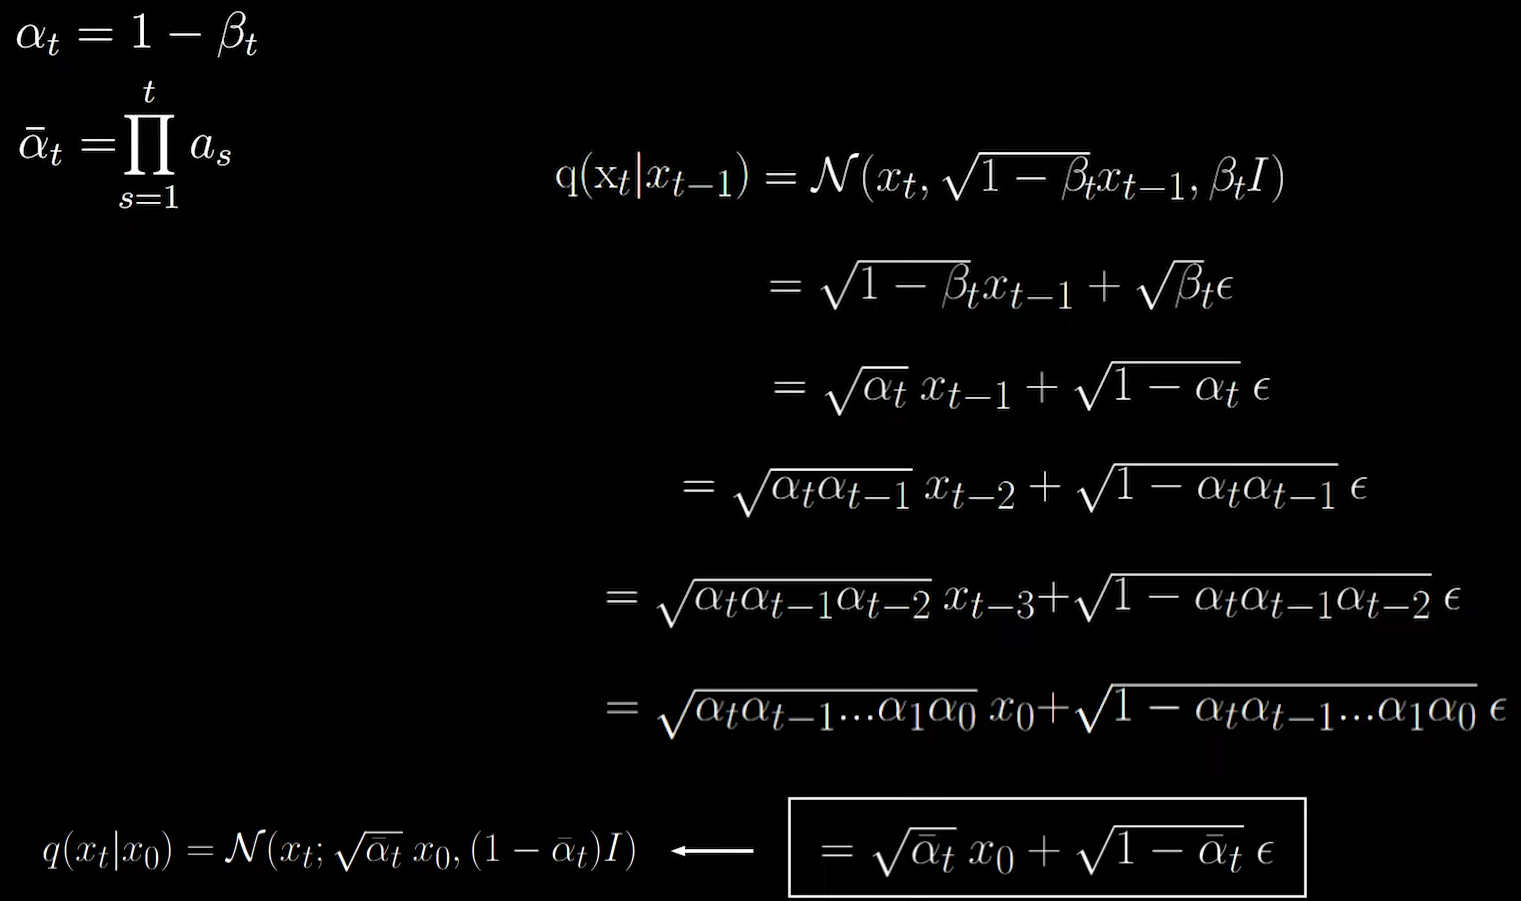

In [8]:
def linear_scheduler(timesteps, start=0.0001, end=0.02):

    """
    Returns linear schedule for beta
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):

    """
    Returns values from vals for corresponding timesteps
    while considering the batch dimension.

    """
    batch_size = t.shape[0]
    output = vals.gather(-1, t.cpu())
    return output.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it after adding noise t times.
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)

    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_scheduler(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# U-Net Architecture

## ***U-Net Architecture is used to denoise the images and in the process learn the representations.***

![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/latent-diffusion-arch.png)

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()

        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):


        h = self.bn1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb

        h = self.bn2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeds = math.log(10000) / (half_dim - 1)
        embeds = torch.exp(torch.arange(half_dim, device=device) * -embeds)
        embeds = time[:, None] * embeds[None, :]
        embeds = torch.cat((embeds.sin(), embeds.cos()), dim=-1)
        return embeds


class Unet(nn.Module):
    """
    A simplified Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                PositionalEncoding(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )


        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([ConvBlock(down_channels[i], down_channels[i+1],
                                    time_emb_dim) for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([ConvBlock(up_channels[i], up_channels[i+1],
                                        time_emb_dim, up=True) for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):

        # Embedd time
        t = self.time_mlp(timestep)
        x = self.conv0(x)

        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = Unet()
model

Unet(
  (time_mlp): Sequential(
    (0): PositionalEncoding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): ConvBlock(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256

# Loss

## ***After some math heavy processes, we arrive at a simple loss function for training.***

![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png)

In [10]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [55]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, i//stepsize+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

# Dataset

In [35]:
import os
from PIL import Image
class StanfordCars(torch.utils.data.Dataset):
    def __init__(self, root_path, transform = None):
        self.images = [os.path.join(root_path, file) for file in os.listdir(root_path)]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_file = self.images[index]
        image = Image.open(image_file).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [36]:
#data = torchvision.datasets.StanfordCars(root=".", download=True)
data = StanfordCars(root_path="StanfordCars/cars_train")

In [44]:
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(num_samples//cols, cols, i + 1)
        plt.imshow(img)

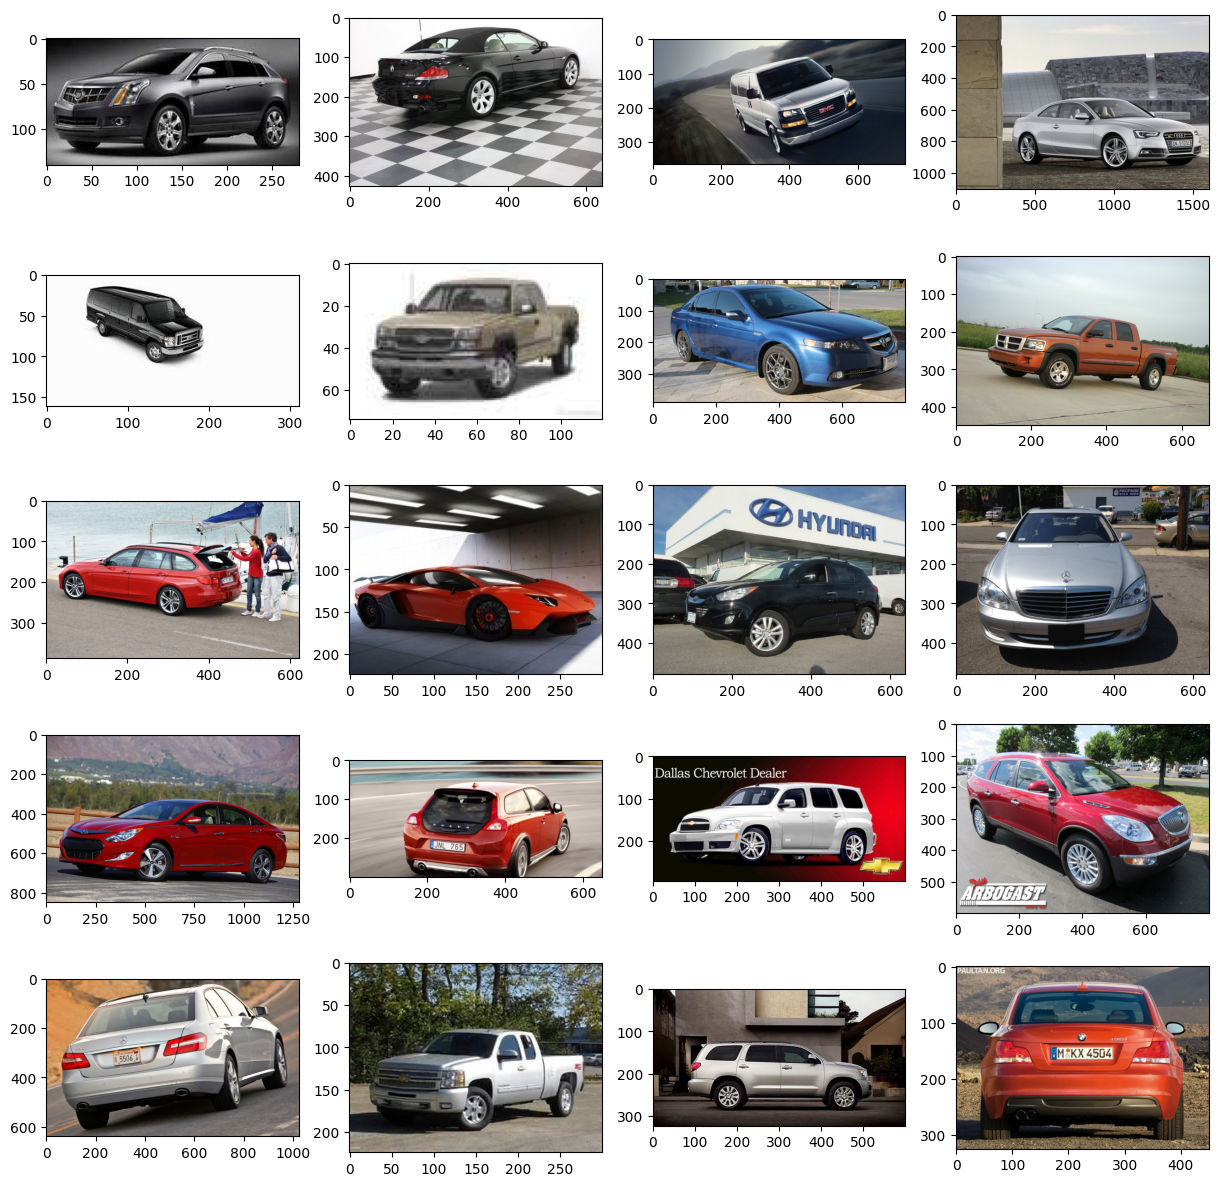

In [45]:
show_images(data)

In [49]:
IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    '''
    Returns data after applying appropriate transformations,
    to work with diffusion models.
    '''
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    train = StanfordCars(root_path="StanfordCars/cars_train",
                         transform=data_transform)

    test = StanfordCars(root_path="StanfordCars/cars_test",
                        transform=data_transform)
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):

    '''
    Plots image after applying reverse transformations.
    '''

    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])


    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

### ***Sample Forward Diffusion***

<ipython-input-51-3b523e3dabf4>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, (idx//stepsize) + 1)


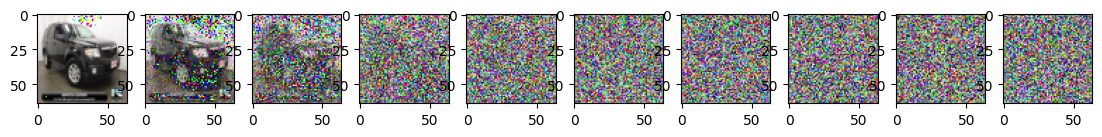

In [51]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, (idx//stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

### ***We can see that the noise being applied at every timestep is too aggresive and image quickly converges to pure noise.***

### ***Many researchers then used different types of beta scheduling other than the linear one we have used, like for example a cosine schedule which adds noise more gradually.***

# Training

In [52]:
from torch.optim import Adam

Epoch 0 | step 000 Loss: 0.7831782102584839 


<ipython-input-55-53a6fe9bdaf8>:39: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, i//stepsize+1)


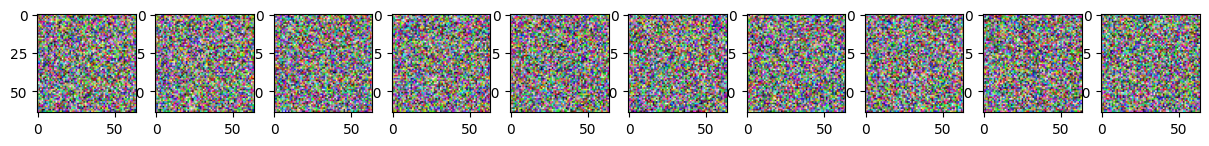

Epoch 5 | step 000 Loss: 0.20559263229370117 


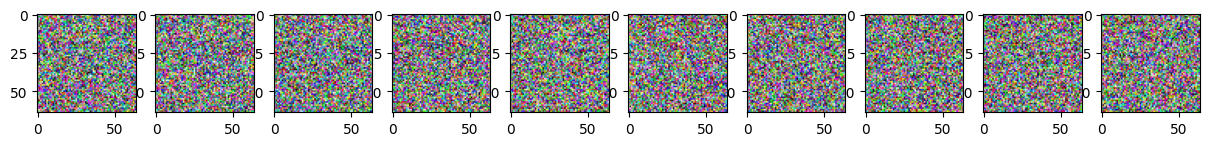

In [ ]:
model.to(device)
optimizer = Adam(model.parameters(), lr=3e-4)
epochs = 100

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch, t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()